<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Replicating the NCX equivalency claim

_by Freya Chay (CarbonPlan)_

This notebook is an attempt to replicate the ton-year calculations reported by NCX in their
previously published white papers.

NCX has published two white papers making ton-year equivalency claims. The latest white paper
([Version 0.5](https://www.google.com/url?q=https://f.hubspotusercontent20.net/hubfs/9337776/Papers/Forests%2520and%2520Carbon_A%2520Guide%2520for%2520Buyers%2520and%2520Policymakers_SilviaTerra2020_v0.4.pdf&source=gmail&ust=1642695487582000&usg=AOvVaw3V7WA3TJEB57E6mVMWlTF2))
asserts that 30.8 tCO2 stored for 1 year is equivalent to a 1 tCO2 emission. This notebook
replicates this result using our understanding of NCX's current ton-year accounting method.

We also compare the replicated method to the implementation of the Lashof method in the `tonyear`
package.

Sources:

- [Version 0.5 RISE White Paper (2021)](https://www.google.com/url?q=https://f.hubspotusercontent20.net/hubfs/9337776/Papers/Forests%2520and%2520Carbon_A%2520Guide%2520for%2520Buyers%2520and%2520Policymakers_SilviaTerra2020_v0.4.pdf&source=gmail&ust=1642695487582000&usg=AOvVaw3V7WA3TJEB57E6mVMWlTF2)
- [Parisa et al. (2021)](https://www.researchsquare.com/article/rs-966946/v1)
- [Jenkins et al. (2021)](https://agu2021fallmeeting-agu.ipostersessions.com/Default.aspx?s=93-9F-22-C2-9D-E7-47-9C-46-65-33-12-9E-10-AE-9F&pdfprint=true&guestview=true)


In [1]:
%load_ext watermark
import sys

import numpy as np
from numpy.testing import assert_array_almost_equal
import matplotlib.pyplot as plt

from carbonplan import styles
import tonyear


styles.mpl.set_theme(style="carbonplan_light", font_scale=1.25)

In [2]:
%watermark -u -i -v -m -g -iv

Last updated: 2022-01-21T22:39:46.910618-05:00

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: ce12432bd8f0ca68060f6f2d776bc8914bde5713

sys       : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
tonyear   : 0.0.post45+dirty
carbonplan: 0.4.0
matplotlib: 3.4.3
numpy     : 1.21.1



## IRF curve


The section below demonstrates that the equivalency ratio reported in the Version 0.5 RISE white
paper, Parisa et al. (2021), and Jenkins et al. (2021) is based on the IRF curve parameterized by
[Joos et al., 2013](https://acp.copernicus.org/articles/13/2793/2013/). We have implemented the
joos_2013 curve in our `tonyear` module.

Parisa et al. (Equation 1) characterize the impulse response function they are using with the
following formula:

$ CO_2ATM(t) = 21.73 + 22.4 * e^{-t / 394.4} + 28.24 * e^{-t / 36.54} + 27.63 * e^{-t / 4.304} $

We implement this function below.


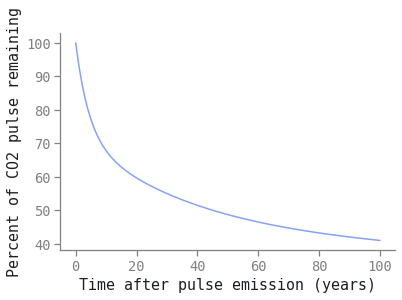

In [3]:
def bern_baseline_curve(t_horizon: int = 1001) -> np.ndarray:

    # parameters from NCX AGU slides
    # cited as Bern Simple Climate Model (TK: add link)
    a = [21.73, 22.40, 28.24, 27.63]
    tau = [0, 394.4, 36.54, 4.304]

    baseline_curve = np.full(t_horizon, a[0])
    for t in range(t_horizon):
        for i in np.arange(1, len(a)):
            baseline_curve[t] += a[i] * np.exp(-t / tau[i])
    return baseline_curve


bern = bern_baseline_curve()
plt.plot(bern[0:101])
plt.ylabel("Percent of CO2 pulse remaining")
plt.xlabel("Time after pulse emission (years)")
plt.show()

This curve is exactly 100x the joos_2013 curve implemented in the `tonyear` package. We can show
this both numerically, and by plotting the two curves against each other. This is probably a units
problem – the parameters used by Parisa et al. and Jenkins et al. respresent the IRF curve in terms
of percentage, while the function implemented in the `tonyear` package returns fractions.


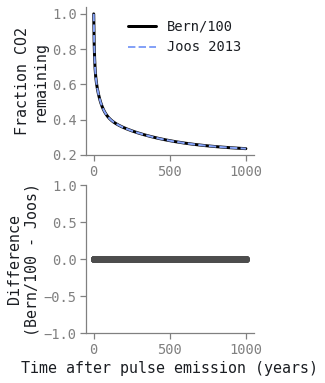

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))
joos_2013 = tonyear.get_baseline_curve("joos_2013")
assert_array_almost_equal(bern / 100, joos_2013)

ax[0].plot(bern / 100, lw=3, c="k", label="Bern/100")
ax[0].plot(joos_2013, ls="--", lw=2, label="Joos 2013")
ax[0].set_ylabel("Fraction CO2\nremaining")
ax[0].legend(frameon=False)

ax[1].scatter(range(len(bern)), bern / 100 - joos_2013, zorder=9, c=".3")
# plt.plot((0,1), (0,1), c="r", ls="--")
ax[1].set_xlabel("Time after pulse emission (years)")
ax[1].set_ylabel("Difference\n(Bern/100 - Joos)")
plt.ylim(-1, 1)
plt.show()

We can precisely replicate Parisa et al.'s Figure 1 using the joos_2013 curve:


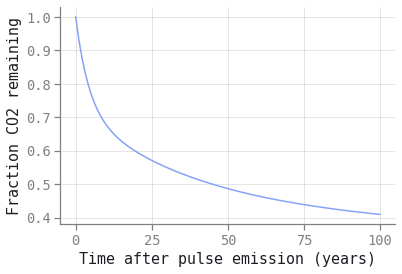

In [5]:
plt.plot(joos_2013[0:101])
plt.grid(alpha=0.2)
plt.xticks([0, 25, 50, 75, 100])
plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlabel("Time after pulse emission (years)")
plt.ylabel("Fraction CO2 remaining")
plt.show()

## Checking claims (IRF Curve)


Using the joos_2013 IRF curve, we can replicate various claims from Parisa et al. (2021) and Jenkins
et al. (2021).


#### Proportion of CO2 pulse emission remaining at 100 years = 41%

Parisa et al. (2021)

> At the end of 100 years, for example, approximately 41% of the original CO2 impulse is expected to
> remain in the atmosphere.


In [6]:
round(joos_2013[101] * 100)

41

#### Before discounting, the ton-year cost of an emission with a 100 year time horizon = 53.07 ton years

Parisa et al. (2021)

> A ton-year is defined as one ton of carbon held for a period of one year in any carbon pool. Using
> the Bern model, we determine the number of ton-years removed from the atmosphere as the result of
> one ton “permanently” sequestered into the biosphere. This is the area under the curve in Figure
> 1, which is 53.07 ton-years of impact on the climate system. In our approach, we track the tons
> for 100 years to be consistent with the 100-year GWPs (GWP100) convention

Jenkins et al. (2021)

> Whereas the total carbon represented under the curve of Figure 1 is 53.07 ton-years...

Pg. 19/30 of V0.5 RISE white paper

> In other words, based on the shape of this curve, 1 ton CO2e is equal to a stream of about 53
> ton-years, delivered over 100 years.


When we integrate under the joos_2013 curve — as we do in the `tonyear` module calculations — we do
not replicate this claim. However, Parisa et al.'s supplementary materials (page 4, Section I.c.)
discuss performing this calculation via summation of the IRF's timestep values rather than
integration of the IRF curve. Using the discrete summation method on the joos_2013 curve, we can
replicate the 53.07 ton year claim.


In [7]:
# integration method
round(np.trapz(joos_2013[:101]), 2)

52.36

In [8]:
# summation method
round(sum(joos_2013[:101]), 2)

53.07

#### After discounting, the ton-year cost of an emission with a 100 year time horizon = 18.69. With a 1000 year time horizon, the ton-year cost is 19.12.

Parisa et al. (2021)

> Whereas the total carbon represented under the curve of Figure 1 is 53.07 ton-years, discounting
> future atmospheric concentrations at 3.3% results in 18.69 ton-years of present value of climate
> impact if the integral is truncated at 100 years, or 19.12 ton-years if the integral is truncated
> at 1000 years.


Using the continuous discount function provided by Parisa et al. (2021), the joos_2013 curve, and a
discount rate of 3.3%, we can replicate their 100 year and 1000 year results.


In [9]:
continuous_discounted_curve = joos_2013 * np.exp(-0.033 * np.arange(len(joos_2013)))
discounted_hundred = round(sum(continuous_discounted_curve[:101]), 2)
discounted_thousand = round(sum(continuous_discounted_curve[:1001]), 2)

print(f"At 100 years:  {discounted_hundred} ton-years")
print(f"At 1000 years: {discounted_thousand} ton-years")

At 100 years:  18.69 ton-years
At 1000 years: 19.12 ton-years


In our ton-year module, we have implemented a slightly different discount function which is copied
below for ease of reference.


In [10]:
def get_discounted_curve(discount_rate: float, curve: np.ndarray) -> np.ndarray:
    """Get discounted curve
    Parameters
    ----------
    discount_rate : float
        Discount rate expressed as a fraction.
    curve : np.ndarray
    Returns
    -------
    discounted_curve : np.ndarray
        Curve with discount rate applied.
    """
    return curve / np.power(1 + discount_rate, np.arange(len(curve)))


discrete_discounted_curve = get_discounted_curve(0.033, joos_2013)
discrete_discounted_hundred = round(sum(discrete_discounted_curve[:101]), 2)
discrete_discounted_thousand = round(sum(discrete_discounted_curve[:1001]), 2)

print(f"At 100 years:  {discrete_discounted_hundred} ton-years")
print(f"At 1000 years: {discrete_discounted_thousand} ton-years")

At 100 years:  18.91 ton-years
At 1000 years: 19.36 ton-years


These two discounting methods produce very similar results. You can see this by plotting the two
discounted IRF curves together, and by plotting the difference between them at each timestep.


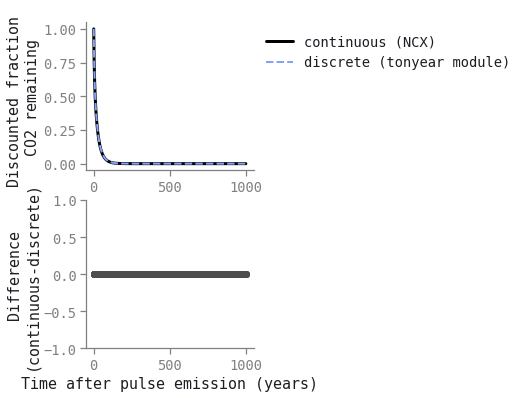

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))

ax[0].plot(continuous_discounted_curve, lw=3, c="k", label="continuous (NCX)")
ax[0].plot(discrete_discounted_curve, ls="--", lw=2, label="discrete (tonyear module)")
ax[0].set_ylabel("Discounted fraction \nCO2 remaining")
ax[0].legend(frameon=False, bbox_to_anchor=(1, 1))

ax[1].scatter(
    range(len(continuous_discounted_curve)),
    continuous_discounted_curve - discrete_discounted_curve,
    zorder=9,
    c=".3",
)
# plt.plot((0,1), (0,1), c="r", ls="--")
ax[1].set_xlabel("Time after pulse emission (years)")
ax[1].set_ylabel("Difference\n(continuous-discrete)")
plt.ylim(-1, 1)
plt.show()

We also use an assert function to show that the discounted values each discounting function produces
are equal up to two decimal places.


In [12]:
assert_array_almost_equal(discrete_discounted_curve, continuous_discounted_curve, decimal=2)

## Checking claims (benefit calculation)


#### With 1 year delay and a 3.3% discount rate, the ton-year cost over 100 years = 18.07; 1000 years = 18.5

Parisa et al. (2021)

> Delaying emissions by one year does not change the area of undiscounted ton-years, but the
> discounted ton-years from a one-year delay total up to 18.07 if truncated at 100 years or 18.50 if
> integrated out to 1000 years.


In [13]:
# create a project curve by shifting the IRF curve over by one year, then discount
project_curve = np.concatenate(([0], joos_2013))
ncx_discounted_project_curve = project_curve * np.exp(-0.033 * np.arange(len(project_curve)))

project_cost_hundred = round(sum(ncx_discounted_project_curve[:101]), 2)
project_cost_thousand = round(sum(ncx_discounted_project_curve[:1001]), 2)
print(f"At 100 years:  {project_cost_hundred} ton-years")
print(f"At 1000 years: {project_cost_thousand} ton-years")

At 100 years:  18.07 ton-years
At 1000 years: 18.5 ton-years


#### A 1 year delay of 1tCO2 = 0.62 ton-year benefit

Parisa et al. (2021)

> The value of a one-year delay in emissions, at a discount rate of 3.3% is thus 18.69 – 18.07 =
> 0.62 ton-years if integrated out to 100 years (or 19.12 – 18.50 = 0.62 ton-years if integrated to
> 1000 years).


In [14]:
benefit_hundred = round(discounted_hundred - project_cost_hundred, 2)
benefit_thousand = round(discounted_thousand - project_cost_thousand, 2)

print(f"At 100 years:  {benefit_hundred} ton-years")
print(f"At 1000 years: {benefit_thousand} ton-years")

At 100 years:  0.62 ton-years
At 1000 years: 0.62 ton-years


Parisa et al.'s description of the benefit calculation — comparing the ton-year cost of an emission
over a specified time horizon with and without the temporary storage delay — is conceptually
identical to the Lashof benefit calculation, though they use summation rather than integration and
implement discounting. See, for instance, the Figure 4 caption of
[Fearnside et al. (2000)](https://doi.org/10.1023/A:1009625122628) or the description of the benefit
calculation on pg. 10:

> The difference between the integrals of the two curves would represent the gain earned from having
> delayed the emission.


## Replicating the equivalence ratio


Parisa et al. (2021)

> At the 3.3% discount rate used in this analysis, we calculate 30.8 tons of carbon need to be
> stored for 1 year to be equivalent in value to 1 ton of carbon stored in perpetuity.

Pg. 20 of V0.5 RISE white paper (2021)

> So, removing and storing 30.8 tons CO2 for one year, this year, has an equivalent climate impact
> to removing 1 ton CO2e, or 1 “permanent ton.”

Below, we use the Parisa et al. method to replicate the 30.8 equivalence claim.


In [15]:
time_horizon = 1000
delay = 1
discount_rate = 0.033
t = np.arange(len(joos_2013))


def NCX_equivalence_claim(irf_curve, time_horizon, delay, discount_rate):
    baseline = irf_curve * np.exp(-discount_rate * t)
    baseline_atm_cost = sum(baseline[: time_horizon + 1])

    scenario = np.concatenate(([0] * delay, irf_curve))[: time_horizon + 1] * np.exp(
        -discount_rate * t[: time_horizon + 1]
    )
    benefit = sum(baseline[: time_horizon + 1]) - sum(scenario[: time_horizon + 1])

    return baseline_atm_cost / benefit


round(NCX_equivalence_claim(joos_2013, time_horizon, delay, discount_rate), 1)

30.8

We can compare this to the Lashof method implemented in our `tonyear` module, run with the same
parameters. To reiterate, the Lashof calculation uses a the same IRF curve, discount rate, delay,
and time horizon. It uses a slightly different function to apply the discount rate, and integrates
under the IRF curve rather than summing the timestep values.


In [16]:
round(
    tonyear.calculate_tonyears("lashof", joos_2013, time_horizon, delay, discount_rate)[
        "num_for_equivalence"
    ],
    1,
)

31.3

We can show the similarity of the NCX approach and the Lashof approach by comparing the equivalence
ratios they calculated for a variety of delays.


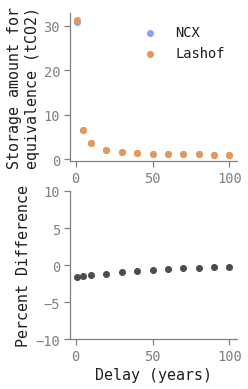

In [17]:
delays = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

NCX_ratios = np.array(
    [NCX_equivalence_claim(joos_2013, time_horizon, delay, discount_rate) for delay in delays]
)
Lashof_ratios = np.array(
    [
        tonyear.calculate_tonyears("lashof", joos_2013, time_horizon, delay, discount_rate)[
            "num_for_equivalence"
        ]
        for delay in delays
    ]
)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))

ax[0].scatter(delays, NCX_ratios, label="NCX")
ax[0].scatter(delays, Lashof_ratios, label="Lashof")
ax[0].set_ylabel("Storage amount for\nequivalence (tCO2)")
ax[0].legend(frameon=False, bbox_to_anchor=(1, 1))

percent_difference = (NCX_ratios - Lashof_ratios) / ((NCX_ratios + Lashof_ratios) / 2) * 100
ax[1].scatter(delays, percent_difference, zorder=9, c=".3")
# plt.plot((0,1), (0,1), c="r", ls="--")
ax[1].set_xlabel("Delay (years)")
ax[1].set_ylabel("Percent Difference")
plt.ylim(-10, 10)
plt.show()

NCX v0.5 and Lashof are quite close. It seems to be the case that the discrepancy is caused by the
differing approaches to discounting.

Discounting appears twice in the function `NCX_equivalence_claim`:

```python
    baseline = irf_curve * np.exp(-discount_rate * t)
    ...
    scenario = np.concatenate(([0] * delay, irf_curve))[: time_horizon + 1] * np.exp(
        -discount_rate * t[: time_horizon + 1]
    )
```

To explore the effect of the discounting funciton, we'll just change those two lines to use
`get_discounted_curve` defined above.


In [18]:
def NCX_equivalence_claim_alternate_discounting(irf_curve, time_horizon, delay, discount_rate):
    baseline = get_discounted_curve(discount_rate, irf_curve)
    baseline_atm_cost = sum(baseline[: time_horizon + 1])

    scenario = get_discounted_curve(
        discount_rate, np.concatenate(([0] * delay, irf_curve))[: time_horizon + 1]
    )
    benefit = sum(baseline[: time_horizon + 1]) - sum(scenario[: time_horizon + 1])

    return baseline_atm_cost / benefit

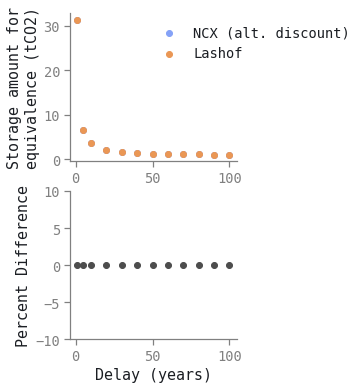

In [19]:
delays = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

NCX_ratios = np.array(
    [
        NCX_equivalence_claim_alternate_discounting(joos_2013, time_horizon, delay, discount_rate)
        for delay in delays
    ]
)
Lashof_ratios = np.array(
    [
        tonyear.calculate_tonyears("lashof", joos_2013, time_horizon, delay, discount_rate)[
            "num_for_equivalence"
        ]
        for delay in delays
    ]
)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3, 6))

ax[0].scatter(delays, NCX_ratios, label="NCX (alt. discount)")
ax[0].scatter(delays, Lashof_ratios, label="Lashof")
ax[0].set_ylabel("Storage amount for\nequivalence (tCO2)")
ax[0].legend(frameon=False, bbox_to_anchor=(1.75, 1))

percent_difference = (NCX_ratios - Lashof_ratios) / ((NCX_ratios + Lashof_ratios) / 2) * 100
ax[1].scatter(delays, percent_difference, zorder=9, c=".3")
# plt.plot((0,1), (0,1), c="r", ls="--")
ax[1].set_xlabel("Delay (years)")
ax[1].set_ylabel("Percent Difference")
plt.ylim(-10, 10)
plt.show()

When we use `get_discounted_curve`, the differences in the NCX v0.5 and Lashof approach are even
smaller. In fact, they're nearly identical. We can check this with an assert statement -- the next
cell will raise an error if the two approaches differ up to six decimal places.


In [20]:
assert_array_almost_equal(NCX_ratios, Lashof_ratios)

## Comparison table


Below, we compare the NCX equivalence results from
[Version 0.4](https://ncx.com/wp-content/uploads/2021/06/Forests-and-Carbon_A-Guide-for-Buyers-and-Policymakers_SilviaTerra2020_v0.4-2-1.pdf)
and
[Version 0.5](https://www.google.com/url?q=https://f.hubspotusercontent20.net/hubfs/9337776/Papers/Forests%2520and%2520Carbon_A%2520Guide%2520for%2520Buyers%2520and%2520Policymakers_SilviaTerra2020_v0.4.pdf&source=gmail&ust=1642695487582000&usg=AOvVaw3V7WA3TJEB57E6mVMWlTF2)
of their RISE white paper to our example calculations using the Moura Costa and Lashof methods
implemented in our ton-year module. We also include the Climate Action Reserve’s implementation of
ton-year accounting from its
[Soil Enrichment Protocol](https://www.climateactionreserve.org/how/protocols/soil-enrichment/).


| Source                   | NCX v0.4 | Moura Costa (Example 1) | NCX v0.5 | Lashof (Example 1) | CAR | Lashof (Example 2) |
| ------------------------ | -------- | ----------------------- | -------- | ------------------ | --- | ------------------ |
| Storage Amount (tCO2)    | 17       | 17.5                    | 30.8     | 31.3               | 100 | 127.7              |
| Storage Period (years)   | 1        | 1                       | 1        | 1                  | 1   | 1                  |
| Time Horizon (years)     | 100      | 100                     | 1000     | 1000               | 100 | 100                |
| Discount Rate (physical) | 3.30%    | 3.30%                   | 3.30%    | 3.30%              | 0   | 0                  |


In [21]:
# Moura Costa (Example 1)
mc_example_1 = tonyear.calculate_tonyears(
    method="mc",
    baseline=tonyear.get_baseline_curve("ipcc_2007"),
    time_horizon=100,
    delay=1,
    discount_rate=0.033,
)
print(round(mc_example_1["num_for_equivalence"], 1))

17.5


In [22]:
# Lashof (Example 1)
lashof_example_1 = tonyear.calculate_tonyears(
    method="lashof", baseline=joos_2013, time_horizon=1000, delay=1, discount_rate=0.033
)
print(round(lashof_example_1["num_for_equivalence"], 1))

31.3


In [23]:
# Lashof (Example 1)
lashof_example_1 = tonyear.calculate_tonyears(
    method="lashof", baseline=joos_2013, time_horizon=100, delay=1, discount_rate=0.0
)
print(round(lashof_example_1["num_for_equivalence"], 1))

127.7
